In [169]:
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [170]:
import numpy as np
import tqdm 
import math

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import snntorch.functional as SF

from snntorch import spikegen

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [171]:
num_events = 30000
num_events_test = 8000

events_arr, muon_list, max_n = ge.generate_noisy_evts(num_events, noise_frac=0.4, bkg_frac=0.5)
events_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(num_events_test, noise_frac=0.4, bkg_frac=0.5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:09<00:00, 873.65it/s]


In [172]:
def target_event(muon_list):
    trueTarget = []
    for event in muon_list:
        trueEvent = []
        for hit in event:
            if hit["signal"] == True:
                trueEvent.append(hit)
    
        trueTarget.append(trueEvent)   
        
    return trueTarget

target = target_event(muon_list)
target_test = target_event(muon_list_test)

In [173]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.input_data = input_data
        self.target = target
        
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        
        input_sample = self.input_data[idx]
        target_sample = self.target[idx]
        
        if self.transform:
            input_sample = self.transform(input_sample)
            target_sample = self.transform(target_sample)
            
        return input_sample, target_sample


# Transformations

# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_hits, size, target_dtype=np.int16,
               features=['layer', 'wire_num', 'bx', 't0']):
    padded_array = np.zeros(shape=(size, len(features)), dtype=target_dtype)
    for i, hit in enumerate(muon_hits):
        for j, f in enumerate(features):
            padded_array[i,j] = hit[f]  # BEWARE: implicit type conversions going on here

    return padded_array

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    tensor = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = tensor.to(target_dtype)
    
    return tensor

feature_list = ['layer', 'wire_num', 'bx', 't0']
transform = transforms.Compose([
    lambda x: convert_to(x, size=max_n, target_dtype=np.float32,
                         features=feature_list),
    lambda x: to_tensor_and_dtype(x, target_dtype=torch.float32)
])

train_dataset = CustomDataset(muon_list, target, transform=transform)
test_dataset = CustomDataset(muon_list_test, target_test, transform=transform)

In [174]:
batch_size = 60
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=nw)

In [187]:
def custom_spikegen(data_it, num_step=40,plain=True):
    
    if plain:
        spike_data = torch.zeros(size=(num_step,batch_size), dtype=data_it.dtype)
    else:
        spike_data = torch.zeros(size=(num_step,batch_size,ps.NLAYERS,ps.NWIRES), dtype=data_it.dtype)
    
    for n_batch, evt in enumerate(data_it):
    
        notZeroBx = evt[evt[:,2] > 0][:,2].numpy()
        if len(notZeroBx) == 0:
            break
        
        startTime = min(500,min(notZeroBx))
            
        for hit in evt[evt[:,2] > 0]:
            
            bx = int(hit[2])
            time = int(bx - startTime)
            
            if not plain:
                layer = int(hit[0])
                wire = int(hit[1])
            
                spike_data[time, n_batch, layer-1, wire-1] = 1
            
            else:
                
                spike_data[time,n_batch] = 1
                
    return spike_data  

In [207]:
# Network Architecture
num_inputs = ps.NLAYERS*ps.NWIRES
num_hidden = 100
num_outputs = 2#num_inputs

# Temporal Dynamics
num_steps = 40
beta = 0.8

In [208]:
# Define Network
class SLSTMnet(nn.Module):
    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()

        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad_lstm = surrogate.fast_sigmoid()

        # initialize layers
        self.slstm1 = snn.SLSTM(self.input_feat, self.hidden,spike_grad=spike_grad_lstm)
        
        self.slstm2 = snn.SLSTM(self.hidden, self.out_feat,spike_grad=spike_grad_lstm)

    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        syn1, mem1 = self.slstm1.init_slstm()
        syn2, mem2 = self.slstm2.init_slstm()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(self.timesteps):
            spk1, syn1, mem1 = self.slstm1(x[step], syn1, mem1)
            spk2, syn2, mem2 = self.slstm2(spk1, syn2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec), torch.stack(mem2_rec)
    
net = SLSTMnet(num_inputs, num_hidden, num_outputs, num_steps).to(device)

In [209]:
def print_batch_accuracy(net, data, targets, batch_size, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    
    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

In [210]:
batch_size = 60
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=nw)

In [231]:
import torch
import torch.nn as nn

# Assuming your batch size is 60 and each element has 40 values
batch_size = 60
num_elements = 40

# Generate some random data for demonstration purposes
predictions = torch.rand((batch_size, num_elements))
targets = torch.randint(0, 2, size=(batch_size, num_elements), dtype=torch.float32)

# Use sigmoid to squash the predictions between 0 and 1
predictions = torch.sigmoid(predictions)

print(targets.shape,predictions.shape)
# Create the BCE loss function
bce_loss = nn.BCELoss()

print(predictions.view(-1).shape)
# Compute the loss element-wise and then take the mean
loss = bce_loss(predictions.view(-1), targets.view(-1))

print("BCE Loss:", loss.item())


torch.Size([60, 40]) torch.Size([60, 40])
torch.Size([2400])
BCE Loss: 0.7326331734657288


In [232]:
num_epochs = 5
loss_hist = []
iter_counter = 0

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))


# Outer training loop
for epoch in range(num_epochs):
    batch_counter = 0
    # Minibatch training loop
    for data_it, targets_it in train_loader:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # create spike train
        spike_in = custom_spikegen(data_it, num_steps,False)
        spike_targets = custom_spikegen(targets_it, num_steps,True)

        spike_in = spike_in.to(device)
        spike_targets = spike_targets.to(device)
        
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(spike_in.view(num_steps, batch_size, -1))
        
        loss_val = torch.tensor(0.)
        for batch_ind in range(batch_size):
            loss_val += loss_fn(spk_rec.squeeze().t()[batch_ind], spike_targets.t()[batch_ind])
            
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
        
        batch_counter += 1
        iter_counter += 1

Epoch: 0
Batch: 0
Iteration: 0
Loss: 10.0 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.0 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.0 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 7.5 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.0 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.0 



KeyboardInterrupt: 

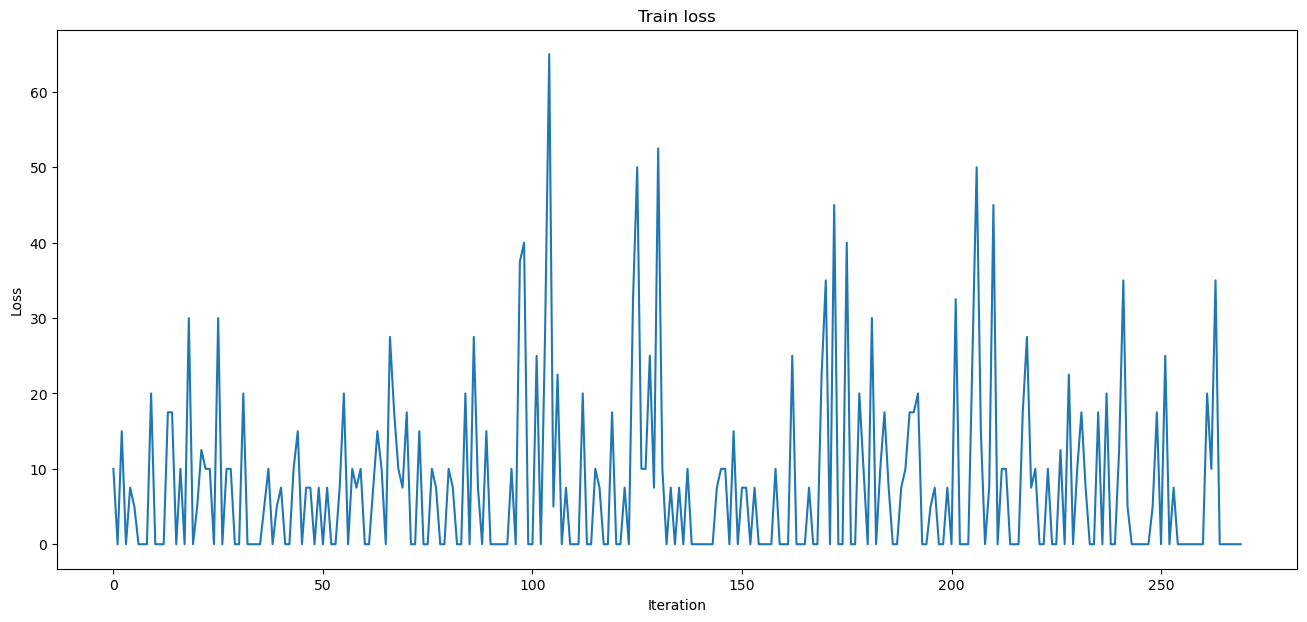

In [233]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(16, 7))
plt.plot(loss_hist)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()